# 필독
---
**코딩 테스트 응시 방법**  
본 파일은 배포용으로, 사본을 만들어 문제 풀이를 진행해주세요.  

**평가 관련**  
문제 해결 능력을 중심으로 평가합니다.  
구현 시, 예제와 같은 구성을 따를 필요는 없습니다.  
필요없다 생각하는 부분을 덜거나, 필요하다 생각하는 부분들을 추가하셔도 됩니다. 완전히 구조가 달라도 상관 없습니다.  

 만일 구현에 실패한 부분이 있다면 무엇을 구현하고자 했지만 실패했는지, 구현 의도와 실패한 코드를 남겨주세요.  

**제출 양식**
- 제목 : [코딩 테스트/단계]이름_ 과 _학번

**구현,작업 관리 주의사항**  
아래 4가지 규칙을 지켜 구현한 코드와 보고서를 함께 제출해주신 모든 벗들과 면접을 진행할 예정입니다. 꼭 읽고 지켜주세요!

- 📍**딥러닝 프레임워크는 pytorch를 사용해주세요.**
- 📍**코드 설명을 달아주세요.**
- 📍**코드 출력을 지우지 말고 제출해주세요.**
- 📍**공유 권한을 설정해주세요.**


# MNIST DataSet에 대하여
---
MNIST dataset은 28x28 규격의 흑백 이미지 데이터 셋입니다. 이 데이터 셋은 0부터 9까지 10개의 라벨이 존재하며 이미지 학습의 대표적인 예제입니다.  
MNIST dataset은 `pytorch.vision`이나 인터넷을 통해 다운 받아 이용할 수 있습니다.

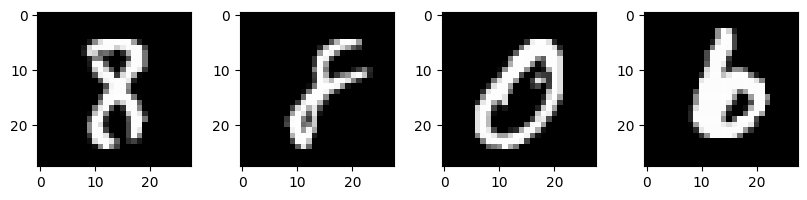

## **1. Import Libraries**
딥러닝 구현에 필요한 핵심 라이브러리를 가져오는 단계.

In [ ]:
# 데이터 처리 및 수학 연산을 위한 라이브러리
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch 관련 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


## **2. Load and Preprocess Data**
MNIST 데이터셋을 로드하고 전처리하는 단계.

- **데이터 로드**: PyTorch의 datasets.MNIST 클래스를 사용하여 손글씨 숫자 이미지 데이터를 다운로드.

- **데이터 분할**: 원본 학습 데이터셋을 8:2 비율로 학습셋과 검증셋으로 나눔.

- **데이터셋 확인**: 각 데이터셋의 크기를 출력하여 확인.

**+ 데이터 정규화**
- transform=ToTensor()는 필수는 아니지만, 안정적인 학습을 위해 권장됨.
- ToTensor() 함수는 PIL 이미지 또는 numpy 배열을 PyTorch Tensor로 변환함.
- 0 ~ 255 정수형 픽셀 값 -> 0 ~ 1 사이의 float32 값 변환

In [ ]:
# 학습 데이터와 테스트 데이터 로드
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               download=True,
                               transform=ToTensor())

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              download=True,
                              transform=ToTensor())

# train 데이터를 학습셋과 검증셋으로 분할 (8:2 비율)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# 데이터셋 크기 확인
print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.4MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 344kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.21MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.07MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Training set size: 48000
Validation set size: 12000
Test set size: 10000


### **DataLoader Setup**

- 학습 데이터는 shuffle을 적용하여 모델이 데이터 순서에 의존하지 않게 하고,<br>
검증 및 테스트 데이터는 평가의 일관성을 위해 shuffle을 적용하지 않음.


In [ ]:
# 데이터로더 설정
batch_size = 64 # 배치 크기는 64

# 학습 데이터 로더
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
# 검증 데이터 로더
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)
# 테스트 데이터 로더
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

### **Visualizing Sample Images**

- 학습 데이터셋에서 랜덤으로 5개의 이미지를 추출하여 이미지와 레이블을 함께 시각화함.

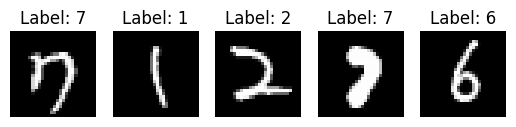

In [ ]:
# 데이터 시각화 함수
def show_sample_images(loader, num_samples=5):
    images, labels = next(iter(loader))
    for i in range(num_samples):
      plt.subplot(1, num_samples, i+1)
      plt.imshow(images[i].squeeze(), cmap='gray')
      plt.title(f'Label: {labels[i]}')
      plt.axis('off')
    plt.show()

# 샘플 이미지 출력
show_sample_images(train_loader)

## **3. Define Model**

MNIST 숫자 분류를 위한 CNN 모델을 정의하는 단계.
<br><br>

**First Convolutional Block**:
  - Conv2d를 사용하여 1채널(흑백 이미지)의 입력을 32채널의 출력으로 변환함.
  - ReLU 활성화 함수와 MaxPool2d 풀링 계층 적용.

**Second Convolutional Block:**
  - Conv2d를 사용하여 32채널의 입력을 64채널로 변환함.
  - ReLU 활성화 함수와 MaxPool2d 풀링 계층 적용.

**Fully Connected Layers:**
  - Flatten()을 통해 2D 텐서를 1D로 변환, Linear 계층을 사용하여 마지막 분류.
  - 과적합을 방지하기 위해 Dropout으로 50%의 확률로 뉴런을 무시함.
  - 출력층은 10개의 출력 클래스로 설정.


<br>

In [ ]:
class MNISTCNN(nn.Module):
    def __init__(self):
        super(MNISTCNN, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    # 순전파 정의
    def forward(self, x):
        x = self.conv1(x)     # Input: 1 x 28 x 28  -> Output: 32 x 14 x 14
        x = self.conv2(x)     # Input: 32 x 14 x 14 -> Output: 64 x 7 x 7
        x = self.fc(x)        # Input: 64 x 7 x 7   -> Output: 10
        return x

# 모델 생성 및 GPU로 이동
model = MNISTCNN().to(device)

# 모델 확인
print(model)

MNISTCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


## **4. Loss Function & Optimizer**

모델 학습에 필요한 손실 함수와 옵티마이저를 설정하는 단계.

In [ ]:
# 학습 파라미터 설정
learning_rate = 0.001
num_epochs = 10

# 손실 함수 정의: Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의: Adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## **5. Training & Validation**

모델 학습 및 검증을 위한 과정을 구현하는 단계.


### **Define Training Mode**

- model.train()으로 모델을 학습 모드로 설정.
- 배치 단위로 데이터를 처리하며 다음 단계를 수행함:
  - 그래디언트 초기화
  - 순전파(forward pass)로 예측값 계산
  - 손실 함수를 통한 오차 계산
  - 역전파(backward pass)로 그래디언트 계산
  - 옵티마이저를 통한 파라미터 업데이트
- 마지막으로, 배치별 손실과 정확도를 누적하여 전체 손실 통계를 계산함.

In [ ]:
# 학습 모드 정의
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 통계 업데이트
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

### **Define Evaluation Mode**

- model.eval()로 모델을 평가 모드로 설정.
- torch.no_grad()를 사용하여 연산 효율성을 높임.

In [ ]:
# 평가 모드 정의
def evaluate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

### **Training Loop**

- 설정된 에폭 수(num_epochs)만큼 반복.
- epoch 별 학습 및 검증 손실과 정확도를 출력.

In [ ]:
# 학습 기록을 위한 리스트
train_losses, train_accs = [], []
val_losses, val_accs = [], []

# 학습 시작
print("Training Started!")
print("-" * 40)

for epoch in range(num_epochs):
    # 학습
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)

    # 검증
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    # 기록 저장
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # 진행상황 출력
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%')
    print(f'Valid - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%')
    print("-" * 40)

Training Started!
----------------------------------------
Epoch [1/10]
Train - Loss: 0.3226, Accuracy: 90.12%
Valid - Loss: 0.0801, Accuracy: 97.53%
----------------------------------------
Epoch [2/10]
Train - Loss: 0.1187, Accuracy: 96.50%
Valid - Loss: 0.0674, Accuracy: 97.87%
----------------------------------------
Epoch [3/10]
Train - Loss: 0.0873, Accuracy: 97.44%
Valid - Loss: 0.0477, Accuracy: 98.50%
----------------------------------------
Epoch [4/10]
Train - Loss: 0.0728, Accuracy: 97.80%
Valid - Loss: 0.0470, Accuracy: 98.58%
----------------------------------------
Epoch [5/10]
Train - Loss: 0.0625, Accuracy: 98.09%
Valid - Loss: 0.0436, Accuracy: 98.76%
----------------------------------------
Epoch [6/10]
Train - Loss: 0.0550, Accuracy: 98.40%
Valid - Loss: 0.0425, Accuracy: 98.69%
----------------------------------------
Epoch [7/10]
Train - Loss: 0.0490, Accuracy: 98.55%
Valid - Loss: 0.0390, Accuracy: 98.81%
----------------------------------------
Epoch [8/10]
Trai

## **6. Evaluate & Visualize**

최종적인 학습 결과와 모델 성능을 시각화하는 단계.

### **Loss & Accuracy Curve**

- Loss 그래프: 학습 손실과 검증 손실을 epoch에 따라 시각화.
- Accuracy 그래프: 학습 정확도와 검증 정확도를 epoch에 따라 시각화.


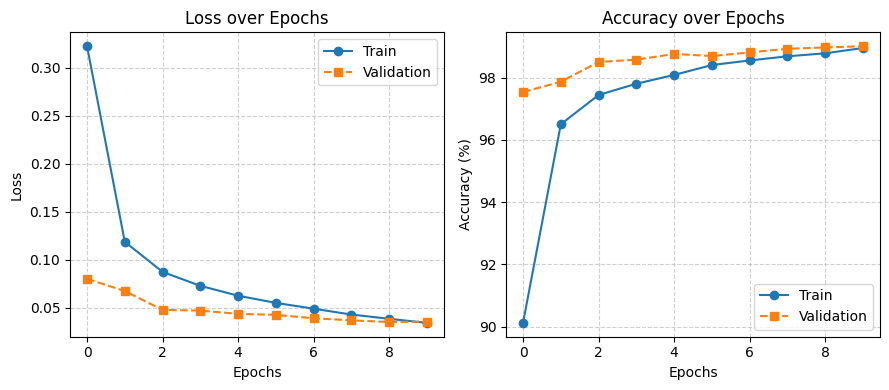

In [ ]:
def training_results(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(9, 4))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train', marker='o', linestyle='-')
    plt.plot(val_losses, label='Validation', marker='s', linestyle='--')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train', marker='o', linestyle='-')
    plt.plot(val_accs, label='Validation', marker='s', linestyle='--')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# 최종 학습 결과 시각화
training_results(train_losses, val_losses, train_accs, val_accs)

### **Confusion Matrix Heatmap**
- 모델의 예측 성능을 Confusion Matrix를 통해 시각화함.

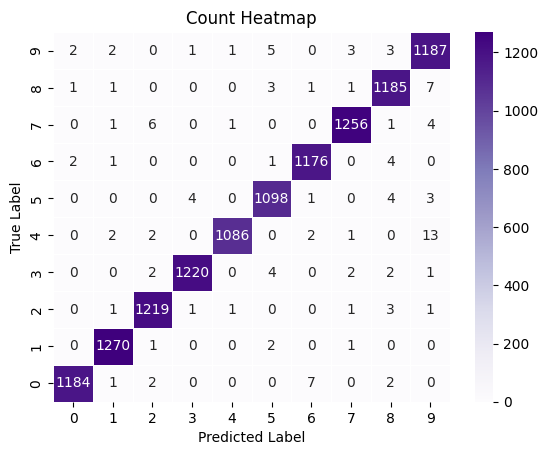

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, data_loader, classes):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            _, predicted = model(images).max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 혼동 행렬 계산 및 반전
    cm = confusion_matrix(all_labels, all_preds)[::-1, :]

    # 히트맵 시각화
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Purples', linewidths=0.5, xticklabels=classes, yticklabels=classes[::-1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Count Heatmap')
    plt.show()

# 클래스 리스트 정의
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# 히트맵 생성
plot_confusion_matrix(model, val_loader, classes)